# Tutorial 1: Cross-modality representation of spatial ATAC mouse embryo samples

The [spatial ATAC mouse embryo samples](https://www.nature.com/articles/s41587-022-01603-9) measured the spatial ATAC-seq profiles of samples from E12.5, E13.5 and E15.5.

In [1]:
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import episcanpy.api as epi
from PRESENT import PRESENT_function

warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(4,4), facecolor="white")

## Analyze E15.5-S1 mouse embryo sample

In [2]:
adata = sc.read_h5ad("Data/E15_5_S1.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 3274 × 248047
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl'
    obsm: 'spatial'


### Run PRESENT model

In [3]:
adata = PRESENT_function(
    spatial_key = "spatial", ## obsm key under which to load the spatial matrix of spots
    adata_atac = adata, ## The ATAC raw fragment count matrix of spots in anndata.AnnData format
    peak_min_cells_fraction = 0.005, ## Minimum fraction of cells accessible required for a peak to pass filtering
    nclusters = adata.obs["clusters"].nunique(),
    device = "cuda" ## Device used for training: cuda or cpu
)
print(adata)

Loading data and parameters...
Input data has been loaded


Computing METIS partitioning...
Done!
Model training:  26%|██████▌                  | 26/100 [02:35<07:22,  5.98s/it, NLL_loss=0.0881, BNN_loss=0.102, MSE_loss=0.483, ES counter=20, ES patience=20]


Early stop the training process


Succeed to find 10 clusters at resolution 1.031
AnnData object with n_obs × n_vars = 3274 × 50
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl', 'nb_features', 'leiden', 'LeidenClusters'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'embeddings'
    obsp: 'distances', 'connectivities'


### Visualization

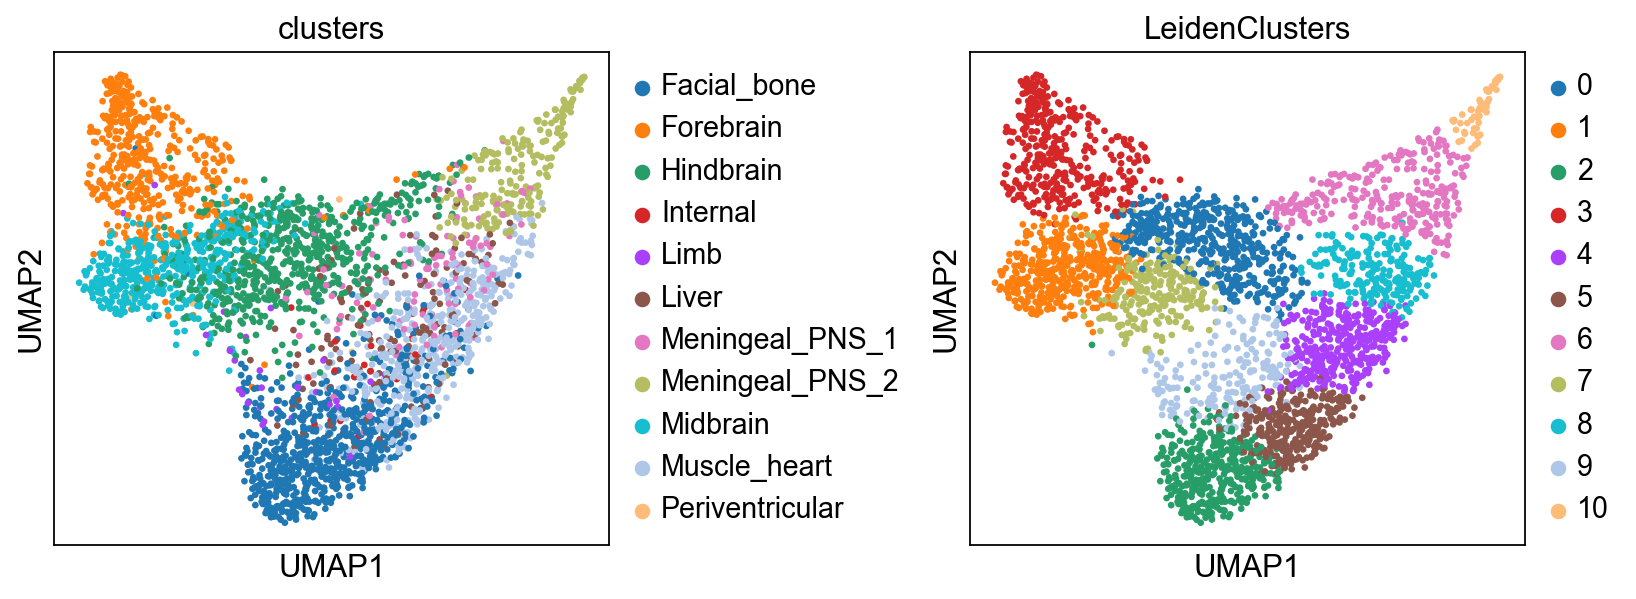

In [4]:
sc.pp.neighbors(adata, use_rep="embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["clusters", "LeidenClusters"], wspace=0.5)

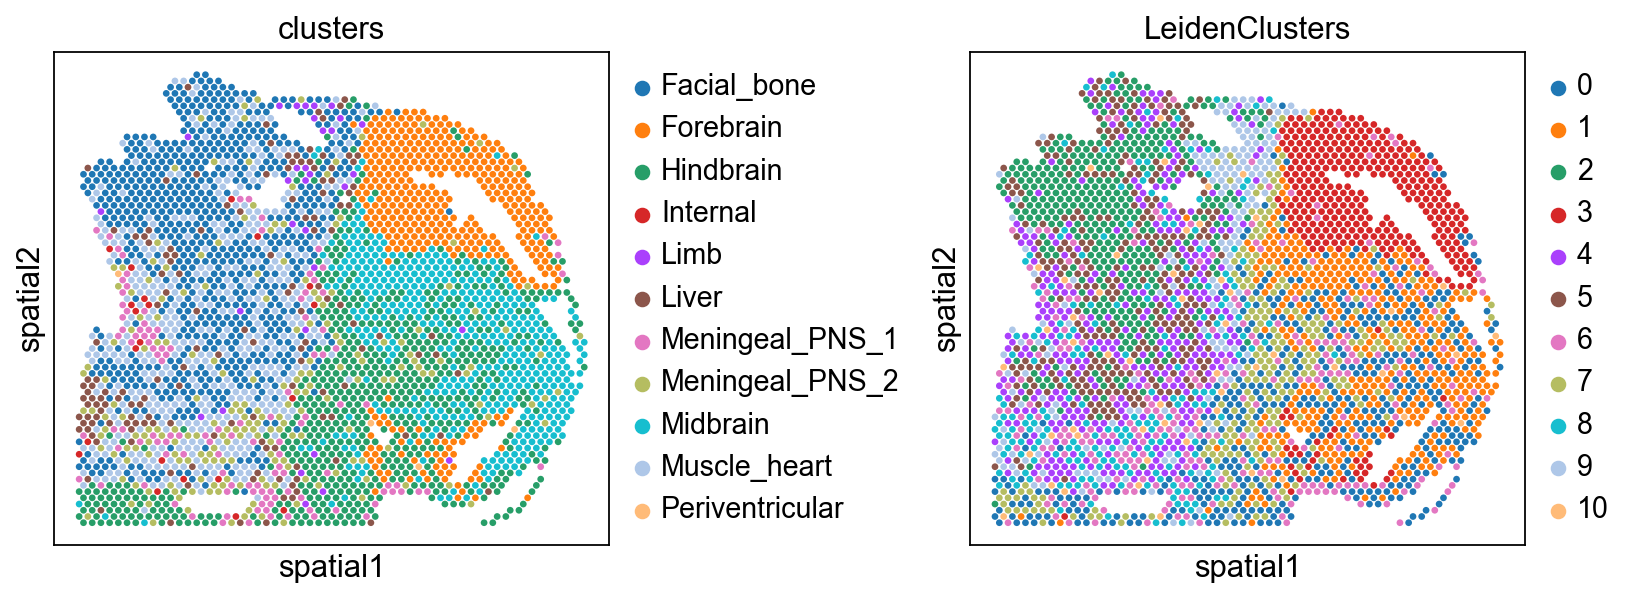

In [5]:
sc.pl.embedding(adata, basis="spatial", color=["clusters", "LeidenClusters"], wspace=0.5)

## Analyze E12.5-S2 mouse embryo sample with a snATAC-seq mouse embryo reference data

Compared with the mouse embryo E15.5-S1 sample, E12.5-S2 sample suffers from low sequencing depth and signal-to-noise ratio. Here we illustrate the analysis with a [mouse embryo snATAC-seq data](https://www.nature.com/articles/s41587-022-01603-9) consisting of cells from E12, E13 and E15

In [6]:
adata = sc.read_h5ad("Data/E12_5_S2.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 2234 × 248047
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl'
    obsm: 'spatial'


Before fed into the model, we transform the format of region name into chromatin:start-end for further peak merging

In [7]:
rdata = sc.read_h5ad("Data/rdata_snATAC_MouseEmbryo.h5ad")
## Transform the name of region into chromatin:start-end format
regions = []
for region in rdata.var_names:
    name, start, end = region.split("-")
    regions.append(name + ":" + start + "-" + end)
rdata.var.index = regions
print(rdata)

AnnData object with n_obs × n_vars = 1879 × 248047
    obs: 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'sample', 'logunique', 'seurat_clusters', 'annotated_integrated_cl'


### Run PRESENT model

In [8]:
adata = PRESENT_function(
    spatial_key = "spatial", ## obsm key under which to load the spatial matrix of spots
    adata_atac = adata, ## The ATAC raw fragment count matrix of spots in anndata.AnnData format
    rdata_atac = rdata, ## The ATAC raw fragment counts of reference data in anndata.AnnData format
    rdata_atac_anno="annotated_integrated_cl", ## rdata_atac.obs key under which to load the annotation
    peak_min_cells_fraction = 0.005, ## Minimum fraction of cells accessible required for a peak to pass filtering
    device = "cuda" ## Device used for training: cuda or cpu
)
print(adata)

Loading data and parameters...
Peak merged
Peak filtered
Matrix merged
Input data has been loaded
Construct pseudo bulk reference data...
DownSample 1 times to get enough pseudo bulks!
Finished, bulk_data's shape: (30, 72451)


Computing METIS partitioning...
Done!
Model training:  30%|███████▌                 | 30/100 [01:36<03:44,  3.20s/it, NLL_loss=0.069, BNN_loss=0.0519, MSE_loss=0.496, ES counter=20, ES patience=20]


Early stop the training process


Succeed to find 10 clusters at resolution 0.750
AnnData object with n_obs × n_vars = 2234 × 50
    obs: 'nCount_peaks', 'nFeature_peaks', 'nCount_RNA', 'nFeature_RNA', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'y', 'x', 'pixel_y', 'pixel_x', 'section', 'sample', 'age', 'clusters', 'annotated_integrated_cl', 'nb_features', 'leiden', 'LeidenClusters'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'embeddings'
    obsp: 'distances', 'connectivities'


### Visualization

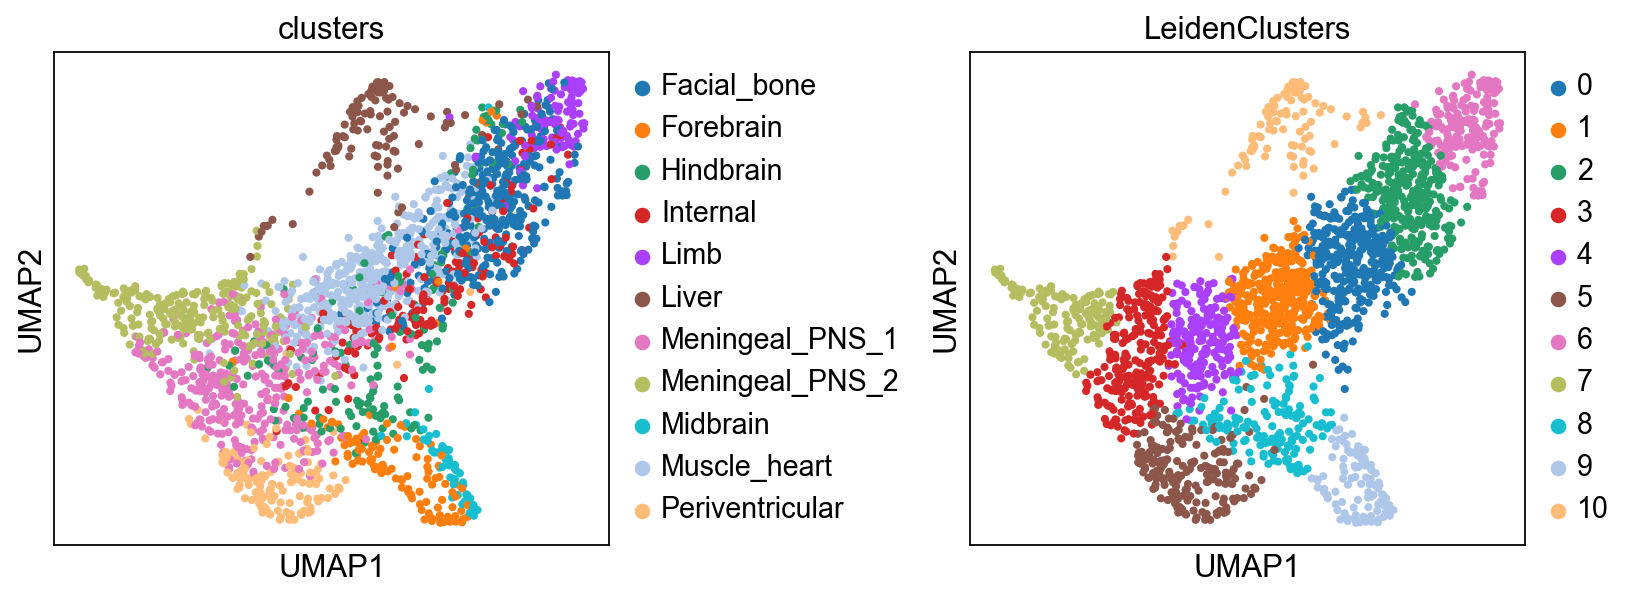

In [9]:
sc.pp.neighbors(adata, use_rep="embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["clusters", "LeidenClusters"], wspace=0.5)

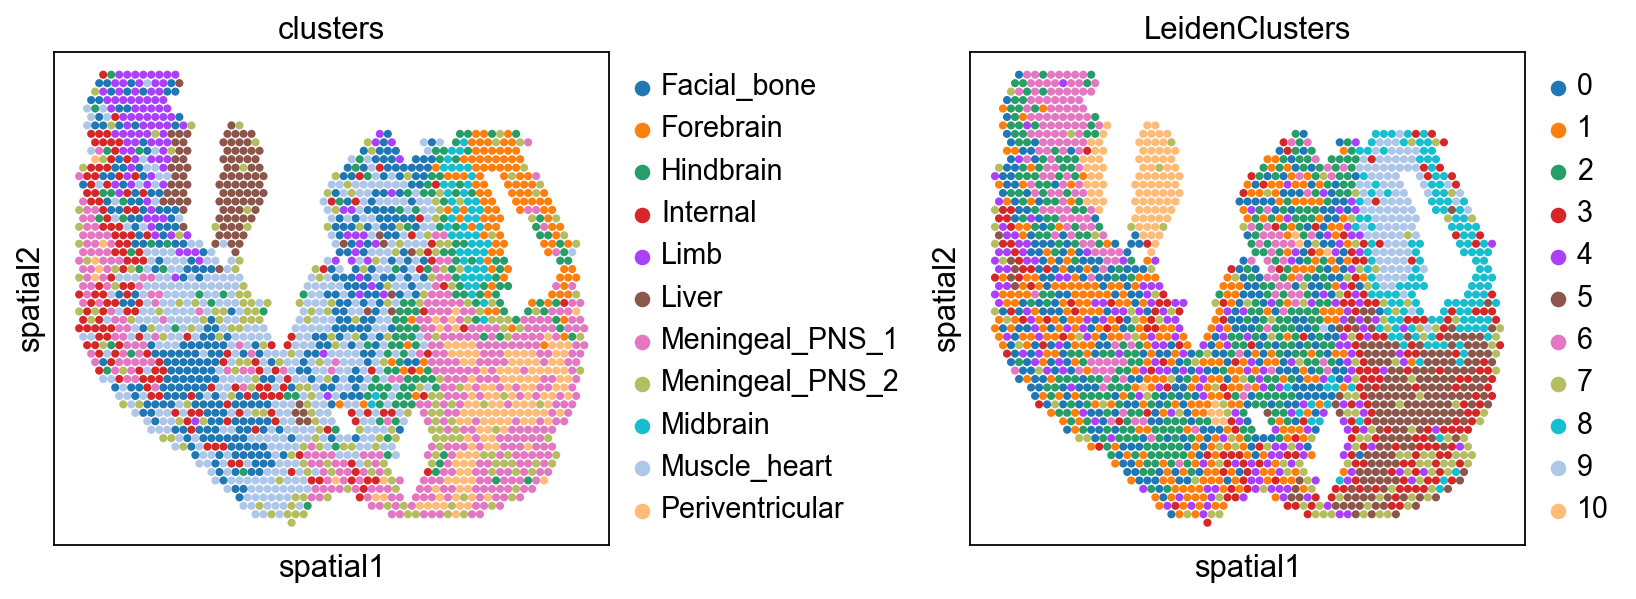

In [10]:
sc.pl.embedding(adata, basis="spatial", color=["clusters", "LeidenClusters"], wspace=0.5)